# Parallel bwtzip speedup analysis  (pbwtzip)

## Introduction

The aim of this notebook is to analyze and evaluate the performance improvements obtained through the parallelization of the bwtzip loseless compression algorithm.

**pbwtzip** is the parallel version of the bwtzip library. It has been developed starting from the sequential original code of bwtzip and then parallelized by the use of OpenMP APIs. Moreover, some changes have been made to the code and internal data structures in order to achieve a good parallelization strategy. 


## Sequential bwtzip

The sequential version of bwtzip can be schematized by **4 functions** that are sequentially applied to a chunk of data to be compressed. A chunk of data is read from the input file and write, after compression, to the output file.


```python
bwtCompress(data_chunk) {
    bwtfxn(data_chunk)      # F1: SuffixTree
    mtf2(data_chunk)        # F2: Move-To-Front (MTF)
    zleWheeler(data_chunk)  # F3: Wheeler Zero Length Encoder
    arith(data_chunk)       # F4: Arithmetic Coding
}

while(data_chunk = file_in.read_chunk()) {
    bwtCompress(data_chunk)
    file_out.append(data_chunk)
}

```


## Parallel bwtzip

To parallelize the functions, since the have execution time very  execution a **pipeline of stages** was created. 

The pipeline has been organized in 3 stages (+1 reader, +1 writer)

#### Functions per stage

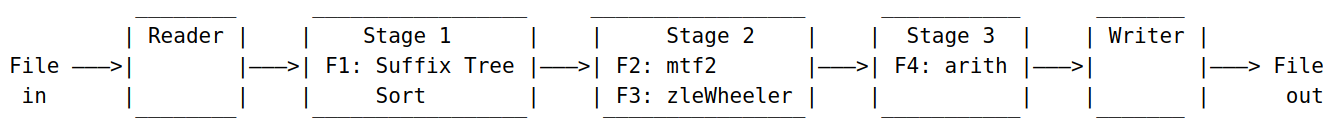

<!-- image was encoded to avoid resize problems, below the original code:
```
          ________      _________________     _________________      ___________      _______      
         | Reader |    |    Stage 1      |    |     Stage 2    |    |  Stage 3  |    | Writer |        
File ———>|        |———>| F1: Suffix Tree |———>| F2: mtf2       |———>| F4: arith |———>|        |———> File
 in      |        |    |     Sort        |    | F3: zleWheeler |    |           |    |        |      out
          ‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾      
```
-->

In between each stage, a double-sided buffer is present to let stages write and read without collisions.

#### Pipeline overview

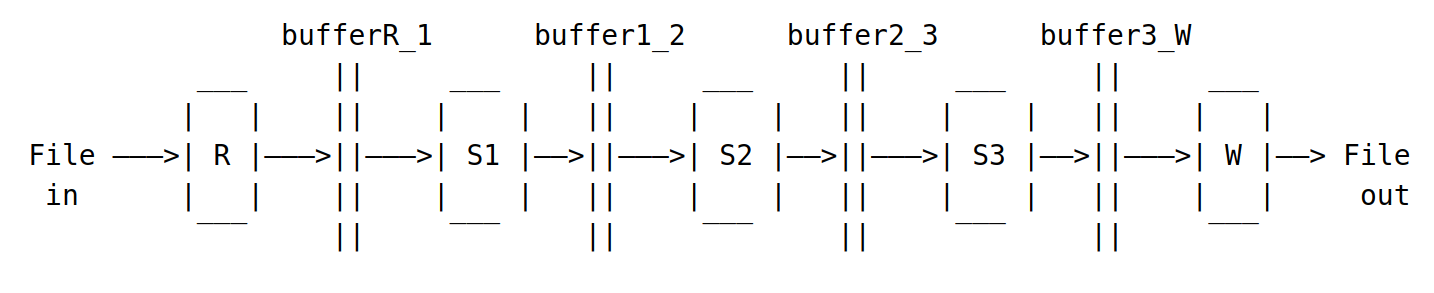

<!-- image was encoded to avoid resize problems, below the original code:
```
               bufferR_1      buffer1_2      buffer2_3      buffer3_W            
          ___     ||     ___     ||     ___     ||     ___     ||     ___ 
         |   |    ||    |    |   ||    |    |   ||    |    |   ||    |   |  
File ———>| R |———>||———>| S1 |——>||———>| S2 |——>||———>| S3 |——>||———>| W |——> File
 in      |   |    ||    |    |   ||    |    |   ||    |    |   ||    |   |     out
          ‾‾‾     ||     ‾‾‾     ||     ‾‾‾     ||     ‾‾‾     ||     ‾‾‾  
          
```
-->

#### Workflow

Buffers are of size **K per side**. Hence K\*2 chunks of data are overall stored in the buffer.

At each pipeline iteration every stage withdraw **K** chunks of data from the buffer preceding it and, after performing the functions assigned, it writes them to the buffer after the stage.
Only exceptions to this are: 
 - Reader: only fill the buffer following it with the chunks read from input file
 - Writer: only read the buffer preceding it and write compressed data chunks to output file

The **k parameter** is defined at runtime based on the thread configuration passed as parameter to pbwtzip.

#### Threads configuration

The threads configuration is the parallelization layout that is used by pbwtzip to assign number of threads to the stages, so to run "multiple instances" of them in parallel over differen chunks of data.

For example, the thread configuration: `5.2.1` would assign

- 5 threads&nbsp;to Stage 1
- 2 threads&nbsp;to Stage 2
- 1 thread&nbsp;&nbsp; to Stage 3


#### K parameter

The k parameter is *automatically set at runtime* to the highest number of threads assigned. For example, by providing a thread configuration like `8.2.1` it will be set to K=`8`. The K parameter, as already said, will be the size of the side of double-sided buffers so to promote the highest parallelism and least collisions as possible.


## Parameters space

Then, the parameters that can be used to change the pbwtzip exectuon performances are:

- chunk size
- thread configuration

The below shown comparison will highlight the speedup optained with the parallel version bwtzip with reespect to its sequential version.


## Speedup computation

**Sequential execution time**

Time required to run the **best sequential algorithm** on one processor&nbsp;&nbsp;&nbsp;&nbsp;$T^*(n)$

**Parallel execution time**

Time required by the parallel algorithm to run on **p processors**&nbsp;&nbsp;&nbsp;$T_p(n)$


### Speedup
Optained speedup on p processors 

$$Speedup = \frac{T^*(n)}{T_p(n)}$$


## Data used for the tests 

The below reported results have been obtained by running this notebook on the files:





## Hardware characteristics

The following tests have been run on a
> Macbook Pro 8,3 Early 2011 shipping a Intel(R) Core(TM) i7-2860QM CPU @ 2.50GHz.


#### Warning

In order **to run this notebook properly**, please do compile the project being sure that the defines at the top of `include/log.hh` are:

```c
#define LOG_SUFFIX_TREE 0
#define LOG_DFS 0
#define LOG_BWTZIP 0
#define LOG_BWTUNZIP 0

#define LOG_PBWTZIP 0
#define LOG_STAGE 0
#define LOG_CHUNKS 0
#define LOG_TEST 0
#define LOG_STATISTICS 0

#define LOG_STATISTICS_CSV 1
```


In [1]:
from utils_execution import get_sequential_compression_times, get_pbwtzip_parallel_compression_times

In [2]:
# in Kb
chunk_sizes = [ 22, 24, 30, 50, 60, 100] #8, 16, 18, 20,
# converted in bytes
chunk_sizes = [int(x*1024) for x in chunk_sizes]

thread_confs = ['3.1.1', '4.1.1', '5.1.1', '6.2.1']

In [ ]:
# compute sequential compression times according to chunk sizes
sequential_compression_times = get_sequential_compression_times(chunk_sizes)

22528
24576
30720
51200
61440
102400
Repetition  0 performed
[1.282223 1.266958 1.296107 1.587016 1.497305 1.810384]


In [ ]:
print(sequential_compression_times)

[1.282223 1.266958 1.296107 1.587016 1.497305 1.810384]


In [ ]:
# compute parallel compression times according to chunk sizes and thread conf
parallel_compression_times = get_pbwtzip_parallel_compression_times(chunk_sizes, thread_confs)

3.1.1 22528
4.1.1 22528
5.1.1 22528
6.2.1 22528
3.1.1 24576
4.1.1 24576
5.1.1 24576
6.2.1 24576
3.1.1 30720
4.1.1 30720
5.1.1 30720
6.2.1 30720
3.1.1 51200
4.1.1 51200
5.1.1 51200
6.2.1 51200
3.1.1 61440
4.1.1 61440
5.1.1 61440
6.2.1 61440
3.1.1 102400
4.1.1 102400
5.1.1 102400


In [ ]:
print(parallel_compression_times)

In [ ]:
# compute speedup
speedup = (sequential_compression_times / parallel_compression_times.T).T

In [ ]:
print(speedup)

In [ ]:
print("Sequential_compression_times\n", sequential_compression_times)
print("\nParallel_compression_times\n", parallel_compression_times)
print("\nSpeedup\n", speedup)


In [ ]:
import pandas as pd
from utils_visualization import get_vis_cnk_sizes, plot_line_chart, plot_heatmap, plot_3d_bar

df = pd.DataFrame(data=speedup, index=get_vis_cnk_sizes(chunk_sizes), columns=thread_confs)  
df = df.round(2)

# Results visualization

## Numeric values

In [ ]:
df.style

## Line chart

In [ ]:
plot_line_chart("Speedup", speedup, chunk_sizes, thread_confs)

## Heat maps

In [ ]:
plot_heatmap('Speedup', speedup, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'Blues', 'red')

In [ ]:
plot_heatmap('Time', parallel_compression_times, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'Greens', 'black')

## 3D bar histograms 

In [ ]:
plot_3d_bar('Speedup', speedup, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'b')

In [ ]:
plot_3d_bar('Time', parallel_compression_times, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'g')